In [1]:
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np


In [2]:

# Cargar datos
print("Cargando datos...")
df = pd.read_csv('datos_ml.csv')
print(f"Total filas: {len(df)}")
print(f"Total columnas: {len(df.columns)}")

# Ver distribución de la variable objetivo
print("\nDistribución de desertor:")
print(df['desertor'].value_counts())
print(f"Tasa deserción: {df['desertor'].mean()*100:.2f}%")

# PASO 1: Procesar perdidas_por_depto (convertir de string a columnas)
print("\nProcesando perdidas por departamento...")

def extraer_perdidas_depto(row):
    try:
        depto_dict = eval(row)  # Convierte string a dict
        return depto_dict
    except:
        return {}

# Obtener todas las categorías únicas
todas_categorias = set()
for idx, row in df.iterrows():
    depto_dict = extraer_perdidas_depto(row['perdidas_por_depto'])
    todas_categorias.update(depto_dict.keys())

print(f"Categorías de materias encontradas: {todas_categorias}")

# Crear columnas para cada categoría
for categoria in todas_categorias:
    col_name = f"perdidas_{categoria.replace(' ', '_')}"
    df[col_name] = df['perdidas_por_depto'].apply(
        lambda x: extraer_perdidas_depto(x).get(categoria, 0)
    )

# Eliminar la columna original
df = df.drop(columns=['perdidas_por_depto'])

# PASO 2: Rellenar valores nulos en variables numéricas
print("\nRellenando valores nulos...")

columnas_numericas = ['edad', 'estrato', 'promedio', 'materias_cursadas', 
                      'materias_perdidas', 'materias_repetidas', 'semestre_actual',
                      'icfes_total', 'icfes_matematicas', 'icfes_lectura', 
                      'icfes_ciencias', 'icfes_sociales', 'icfes_ingles',
                      'es_barranquilla', 'es_colombia', 'graduado']

for col in columnas_numericas:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# PASO 3: Rellenar valores nulos en variables categóricas
columnas_categoricas = ['genero', 'programa', 'tipo_estudiante', 'tipo_admision',
                        'estado_academico', 'departamento', 'ciudad', 'pais',
                        'tipo_colegio', 'calendario_colegio', 'becado', 'discapacidad']

for col in columnas_categoricas:
    if col in df.columns:
        df[col].fillna('Desconocido', inplace=True)

print(f"\nValores nulos restantes: {df.isnull().sum().sum()}")

# Guardar datos limpios
df.to_csv('datos_limpios.csv', index=False)
print(f"\nDatos limpios guardados: datos_limpios.csv")
print(f"Total columnas finales: {len(df.columns)}")
print(f"Columnas: {list(df.columns)}")


Cargando datos...
Total filas: 10226
Total columnas: 30

Distribución de desertor:
desertor
0    9749
1     477
Name: count, dtype: int64
Tasa deserción: 4.66%

Procesando perdidas por departamento...
Categorías de materias encontradas: {'Dpto. Derecho', 'Dpto. Lenguas Extranjeras', 'Dpto. Español', 'Dpto. de Economía', 'Dpto. Humanidades y Filosofía', 'Dpto. Psicología', 'Dpto. Química y Biología', 'Dpto. Salud Pública', 'Dpto. Ing. Civil y Ambiental', 'Dpto. Odontología', 'Dpto. Cs Politica y Rel Intern', 'Dpto. Historia y Cs. Sociales', 'Dpto. Ingeniería de Sistemas', 'Dpto. Ingeniería Mecánica', 'Dpto. Finanzas y Contaduría', 'Dpto. Diseño', 'Dpto. Educación', 'Dpto. Arquitectura y Urbanismo', 'Dpto. Ingeniería Industrial', 'Dpto. Matematicas y estadístic', 'Dpto. Emprendim y Management', 'Dpto. Comunicación Social', 'Dpto. Música', 'Dpto. Física', 'Dpto.Ing Eléctrica-Electrónica', 'Dpto. Enfermería', 'Dpto. Mercadeo y Neg. Internac', 'Dpto. Medicina'}

Rellenando valores nulos...


C:\Users\claud\AppData\Local\Temp\ipykernel_20476\1458097616.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\claud\AppData\Local\Temp\ipykernel_20476\1458097616.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [3]:
import pickle

In [4]:
y = df['desertor']
X = df.drop(columns=['desertor'])

print(f"\nForma de X: {X.shape}")
print(f"Forma de y: {y.shape}")

# Identificar columnas categóricas
columnas_categoricas = ['genero', 'programa', 'tipo_estudiante', 'tipo_admision',
                        'estado_academico', 'departamento', 'ciudad', 'pais',
                        'tipo_colegio', 'calendario_colegio', 'becado', 'discapacidad']

# Diccionario para guardar los encoders
encoders = {}

print("\nCodificando variables categóricas...")
for col in columnas_categoricas:
    if col in X.columns:
        print(f"- {col}: {X[col].nunique()} categorías")
        
        # Crear y entrenar encoder
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        
        # Guardar encoder
        encoders[col] = le

# Guardar encoders para usarlos después
with open('encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

print("\nEncoders guardados en: encoders.pkl")

# Verificar tipos de datos
print("\nTipos de datos:")
print(X.dtypes.value_counts())

# Guardar datos codificados
X['desertor'] = y  # Agregar de vuelta la variable objetivo
X.to_csv('datos_codificados.csv', index=False)

print("\nDatos codificados guardados: datos_codificados.csv")
print(f"Columnas finales: {len(X.columns)}")


Forma de X: (10226, 56)
Forma de y: (10226,)

Codificando variables categóricas...
- genero: 2 categorías
- programa: 28 categorías
- tipo_estudiante: 6 categorías
- tipo_admision: 7 categorías
- estado_academico: 10 categorías
- departamento: 70 categorías
- ciudad: 234 categorías
- pais: 18 categorías
- tipo_colegio: 3 categorías
- calendario_colegio: 4 categorías
- becado: 3 categorías
- discapacidad: 13 categorías

Encoders guardados en: encoders.pkl

Tipos de datos:
int64      48
float64     8
Name: count, dtype: int64

Datos codificados guardados: datos_codificados.csv
Columnas finales: 57


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

In [6]:
# Cargar datos CODIFICADOS (no el df original)
df = pd.read_csv('datos_codificados.csv')

y = df['desertor']
X = df.drop(columns=['desertor'])

print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")

# PASO 1: Dividir en train y test (70% train, 30% test)
print("\nDividiendo datos...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42,
    stratify=y  # Mantiene la proporción de desertores
)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Verificar distribución
print(f"\nDistribución train - Desertores: {y_train.mean()*100:.2f}%")
print(f"Distribución test - Desertores: {y_test.mean()*100:.2f}%")

# PASO 2: Escalar datos (StandardScaler)
print("\nEscalando datos...")
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos escalados")

# PASO 3: Guardar scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler guardado: scaler.pkl")

# PASO 4: Guardar datos divididos
import numpy as np

np.save('X_train.npy', X_train_scaled)
np.save('X_test.npy', X_test_scaled)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

print("\nDatos guardados:")
print("- X_train.npy")
print("- X_test.npy")  
print("- y_train.npy")
print("- y_test.npy")

Forma de X: (10226, 56)
Forma de y: (10226,)

Dividiendo datos...
X_train: (7158, 56)
X_test: (3068, 56)
y_train: (7158,)
y_test: (3068,)

Distribución train - Desertores: 4.67%
Distribución test - Desertores: 4.66%

Escalando datos...
Datos escalados
Scaler guardado: scaler.pkl

Datos guardados:
- X_train.npy
- X_test.npy
- y_train.npy
- y_test.npy


In [7]:
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import pickle
import matplotlib.pyplot as plt


In [8]:



# PASO 1: Cargar datos divididos

X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')


In [9]:
# ========================================
# BALANCEO OPTIMIZADO DE CLASES
# ========================================

# SMOTE moderado (35% desertores)
print("Aplicando SMOTE con sampling_strategy=0.35...")
smote = SMOTE(sampling_strategy=0.35, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Datos balanceados:")
print(f"  - No desertores: {(y_train_balanced == 0).sum()}")
print(f"  - Desertores: {(y_train_balanced == 1).sum()}")
print(f"  - Proporción desertores: {y_train_balanced.mean()*100:.2f}%")

# Class weights moderados (x1.5)
print("\nCalculando class weights con ajuste moderado...")
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train_balanced), 
    y=y_train_balanced
)

# Peso moderado para desertores (x1.5)
class_weight_dict = {
    0: class_weights[0], 
    1: class_weights[1] * 1.5  # Peso x1.5 para desertores
}

print(f"Class weights balanceados:")
print(f"  - No desertor (0): {class_weight_dict[0]:.4f}")
print(f"  - Desertor (1): {class_weight_dict[1]:.4f}")


Aplicando SMOTE con sampling_strategy=0.35...
Datos balanceados:
  - No desertores: 6824
  - Desertores: 2388
  - Proporción desertores: 25.92%

Calculando class weights con ajuste moderado...
Class weights balanceados:
  - No desertor (0): 0.6750
  - Desertor (1): 2.8932


In [10]:
# ========================================
# ARQUITECTURA BALANCEADA CON REGULARIZACIÓN
# ========================================
# Red con regularización L2 para evitar overfitting

from tensorflow.keras import regularizers

n_features = X_train_balanced.shape[1]

model = keras.Sequential([
    # Capa 1: 128 neuronas con L2 regularization
    layers.Dense(128, activation='relu', 
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(n_features,)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    # Capa 2: 64 neuronas con L2 regularization
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    # Capa 3: 32 neuronas con L2 regularization
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Capa 4: 16 neuronas
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    
    # Capa de salida: 1 neurona con sigmoid
    layers.Dense(1, activation='sigmoid')
])

print("Arquitectura balanceada creada:")
print(f"  - 4 capas ocultas (128 → 64 → 32 → 16)")
print(f"  - Regularización L2 (0.001) en primeras 3 capas")
print(f"  - Dropout alto (0.4) para prevenir overfitting")
print(f"  - Total parámetros: ~{sum([np.prod(w.shape) for w in model.trainable_weights]):,}")


Arquitectura balanceada creada:
  - 4 capas ocultas (128 → 64 → 32 → 16)
  - Regularización L2 (0.001) en primeras 3 capas
  - Dropout alto (0.4) para prevenir overfitting
  - Total parámetros: ~18,625


c:\Users\claud\anaconda3\envs\Basico\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# PASO 5: Compilar modelo con FOCAL LOSS BALANCEADO
print("\n5. Compilando modelo con Focal Loss balanceado...")
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.65),  # Alpha moderado
    metrics=[
        'accuracy',
        keras.metrics.AUC(name='auc'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision')
    ]
)

print("Modelo compilado con configuración balanceada!")



5. Compilando modelo con Focal Loss balanceado...


NameError: name 'focal_loss' is not defined

In [ ]:
# ========================================
# FOCAL LOSS BALANCEADO
# ========================================
# Loss function con alpha moderado

import tensorflow.keras.backend as K

def focal_loss(gamma=2.0, alpha=0.65):
    """
    Focal Loss balanceado para clases desbalanceadas.
    - gamma: parámetro de enfoque (default 2.0)
    - alpha: peso MODERADO para clase positiva (0.65 para mejor balance)
    """
    def focal_loss_fixed(y_true, y_pred):
        # Evitar log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        
        # Calcular focal loss
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma)
        
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    
    return focal_loss_fixed

print("Focal Loss BALANCEADO definido:")
print("  - Gamma: 2.0 (enfoque en ejemplos difíciles)")
print("  - Alpha: 0.65 (peso MODERADO para desertores)")
print("  - Mejor balance entre recall y precision")


Focal Loss definida correctamente
  - Gamma: 2.0 (enfoque en ejemplos difíciles)
  - Alpha: 0.75 (más peso a desertores)


In [ ]:

# Mostrar arquitectura
print("\nArquitectura del modelo:")
model.summary()

# PASO 6: Configurar callbacks
print("\n6. Configurando callbacks...")

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# PASO 7: Entrenar modelo
print("\n7. Entrenando modelo...")
print("Esto puede tardar varios minutos...")



Arquitectura del modelo:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,353 (235.75 KB)

 Trainable params: 59,361 (231.88 KB)

 Non-trainable params: 992 (3.88 KB)


6. Configurando callbacks...

7. Entrenando modelo...
Esto puede tardar varios minutos...


In [12]:

history = model.fit(
    X_train_balanced, 
    y_train_balanced,
    validation_split=0.15,  # 15% para validación
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


NameError: name 'early_stop' is not defined

In [26]:

print("\n¡Entrenamiento completado!")

# PASO 8: Guardar modelo
print("\n8. Guardando modelo...")
model.save('modelo_desercion.h5')
print("Modelo guardado: modelo_desercion.h5")

# Guardar historial
with open('historial_entrenamiento.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Historial guardado: historial_entrenamiento.pkl")

print("¡ENTRENAMIENTO FINALIZADO!")



¡Entrenamiento completado!

8. Guardando modelo...
Modelo guardado: modelo_desercion.h5
Historial guardado: historial_entrenamiento.pkl
¡ENTRENAMIENTO FINALIZADO!


EVALUACIÓN DEL MODELO CON MEJORAS

1. Cargando modelo y datos...
Modelo cargado
X_test shape: (3068, 56)
y_test shape: (3068,)

2. Haciendo predicciones...
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicciones completadas con threshold = 0.3

3. MÉTRICAS DE EVALUACIÓN:

Reporte de clasificación:
Predicciones completadas con threshold = 0.3

3. MÉTRICAS DE EVALUACIÓN:

Reporte de clasificación:
              precision    recall  f1-score   support

 No Desertor       0.00      0.00      0.00      2925
    Desertor       0.05      1.00      0.09       143

    accuracy                           0.05      3068
   macro avg       0.02      0.50      0.04      3068
weighted avg       0.00      0.05      0.00      3068


ROC-AUC Score: 0.8005

4. Matriz de Confusión:
[[   0 2925]
 [   0  143]]

Desertores detectados: 143 de 143 (100.00%)
Falsos positivos: 2925
Verdaderos negativos: 0
              precision    recall  f1-score   support

 No Desertor     

c:\Users\claud\anaconda3\envs\Basico\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\claud\anaconda3\envs\Basico\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\claud\anaconda3\envs\Basico\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh


Matriz guardada: matriz_confusion_mejorada.png

5. Curva ROC:
Curva ROC guardada: curva_roc_mejorada.png

6. ANÁLISIS DE DIFERENTES THRESHOLDS:
----------------------------------------------------------------------
Threshold 0.2: Recall=1.000 | Precision=0.047 | Detectados=143/143
Threshold 0.3: Recall=1.000 | Precision=0.047 | Detectados=143/143
Threshold 0.4: Recall=1.000 | Precision=0.047 | Detectados=143/143
Threshold 0.5: Recall=1.000 | Precision=0.047 | Detectados=143/143

¡EVALUACIÓN COMPLETADA!
Curva ROC guardada: curva_roc_mejorada.png

6. ANÁLISIS DE DIFERENTES THRESHOLDS:
----------------------------------------------------------------------
Threshold 0.2: Recall=1.000 | Precision=0.047 | Detectados=143/143
Threshold 0.3: Recall=1.000 | Precision=0.047 | Detectados=143/143
Threshold 0.4: Recall=1.000 | Precision=0.047 | Detectados=143/143
Threshold 0.5: Recall=1.000 | Precision=0.047 | Detectados=143/143

¡EVALUACIÓN COMPLETADA!


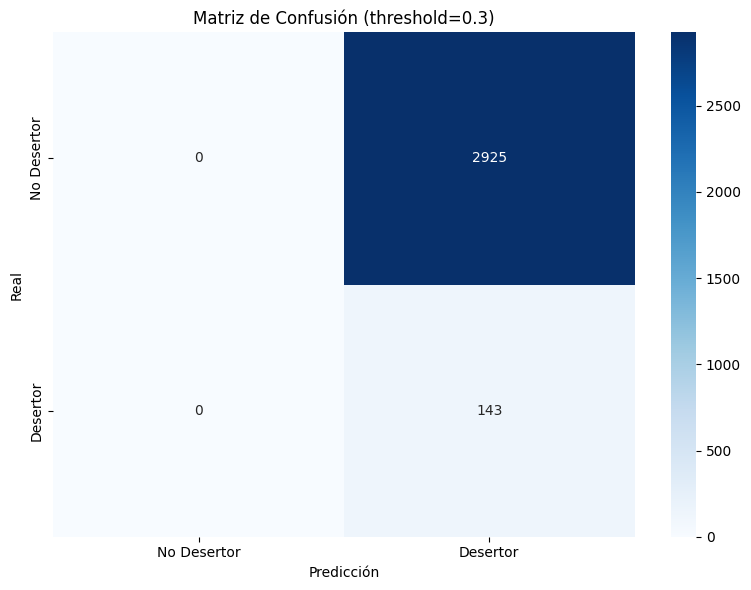

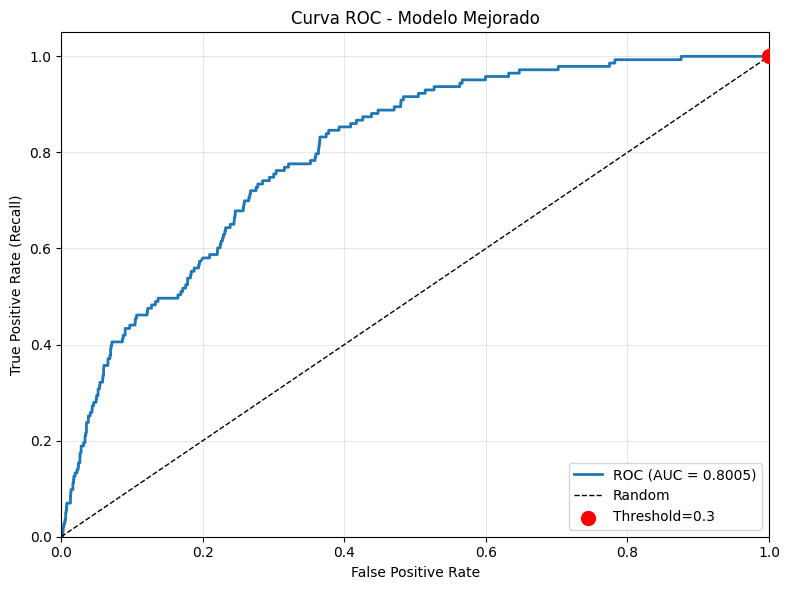

In [27]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 70)
print("EVALUACIÓN DEL MODELO CON MEJORAS")
print("=" * 70)

# PASO 1: Cargar modelo y datos de test
print("\n1. Cargando modelo y datos...")
model = tf.keras.models.load_model('modelo_desercion.h5', compile=False)

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

print(f"Modelo cargado")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# PASO 2: Hacer predicciones con THRESHOLD AJUSTADO
print("\n2. Haciendo predicciones...")
y_pred_proba = model.predict(X_test)

# MEJORA 1: Threshold más bajo para detectar más desertores
THRESHOLD = 0.3  # Bajado de 0.5 a 0.3
y_pred = (y_pred_proba > THRESHOLD).astype(int).flatten()

print(f"Predicciones completadas con threshold = {THRESHOLD}")

# PASO 3: Métricas generales
print("\n3. MÉTRICAS DE EVALUACIÓN:")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Desertor', 'Desertor']))

# ROC-AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {auc_score:.4f}")

# PASO 4: Matriz de confusión
print("\n4. Matriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calcular métricas específicas
tn, fp, fn, tp = cm.ravel()
print(f"\nDesertores detectados: {tp} de {tp+fn} ({tp/(tp+fn)*100:.2f}%)")
print(f"Falsos positivos: {fp}")
print(f"Verdaderos negativos: {tn}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Desertor', 'Desertor'],
            yticklabels=['No Desertor', 'Desertor'])
plt.title(f'Matriz de Confusión (threshold={THRESHOLD})')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.savefig('matriz_confusion_mejorada.png', dpi=300)
print("\nMatriz guardada: matriz_confusion_mejorada.png")

# PASO 5: Curva ROC
print("\n5. Curva ROC:")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.scatter([fp/(fp+tn)], [tp/(tp+fn)], color='red', s=100, zorder=5, 
            label=f'Threshold={THRESHOLD}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC - Modelo Mejorado')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('curva_roc_mejorada.png', dpi=300)
print("Curva ROC guardada: curva_roc_mejorada.png")

# PASO 6: Análisis de threshold óptimo
print("\n6. ANÁLISIS DE DIFERENTES THRESHOLDS:")
print("-" * 70)
for thresh in [0.2, 0.3, 0.4, 0.5]:
    y_pred_temp = (y_pred_proba > thresh).astype(int).flatten()
    cm_temp = confusion_matrix(y_test, y_pred_temp)
    tn_t, fp_t, fn_t, tp_t = cm_temp.ravel()
    
    recall = tp_t / (tp_t + fn_t)
    precision = tp_t / (tp_t + fp_t) if (tp_t + fp_t) > 0 else 0
    
    print(f"Threshold {thresh}: Recall={recall:.3f} | Precision={precision:.3f} | Detectados={tp_t}/{tp_t+fn_t}")

print("\n" + "=" * 70)
print("¡EVALUACIÓN COMPLETADA!")
print("=" * 70)
